### Imports packages

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
import statsmodels.api as sm
from tqdm import tqdm_notebook as tqdm
import scipy.spatial.distance as distance
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from multiprocessing import Pool
import sys
import scipy.stats as stats
from scipy.optimize import minimize

In [2]:
def boxmuller(unif1,unif2):
    u1 = np.sqrt(-2*np.log(unif1))*np.cos(2*np.pi*unif2)
    u2 = np.sqrt(-2*np.log(unif1))*np.sin(2*np.pi*unif2)
    return np.transpose(np.vstack([u1,u2]))

# Function generating standard normals using the box-muller transformation:
def normals(n, d, unif, sv=False):

    # avoid origin
    unif[unif==0] = np.nextafter(0, 1)

    # if d is odd, add one dimension
    if d % 2 != 0:
        dim = d + 1
    else:
        dim = d

    # expand dimensions for SV model
    if sv == True:
        dim = 2+2*d

    # create standard normal samples
    u = np.zeros((n,dim))
    for i in np.arange(0,dim,2):
        u[:,i:(i+2)] = boxmuller(unif[:,i],unif[:,(i+1)])

    # if d is odd, drop one dimension
    if d % 2 != 0 or sv == True:
        u = np.delete(u,-1,1)

    return u

def gen_gandk(z, theta):
    a = theta[0]
    b = theta[1]
    g = theta[2]
    k = np.exp(theta[3])
    g = a+b*(1+0.8*((1-np.exp(-g*z))/(1+np.exp(-g*z))))*((1+z**2)**(k))*z
    return g

def sample_gandk_outl(n,d,theta, n_cont = 0):
    
    cont_size = int(np.floor(int(n_cont)*5/100*n))
    n_real = n - cont_size

    # generate uniforms
    unif = np.random.rand(n_real,d+1)
    unif_outl = np.random.rand(cont_size,d+1)
  
    # generate standard normals  
    z = normals(n_real,d,unif)
    z_outl = normals(cont_size, d, unif_outl)

    # generate samples from g-and-k distribution
    if n_cont != 0:
        #theta_ = np.array([4,2,2,-np.log(3)])
        outl = gen_gandk(z_outl, theta) + 15
        sample = gen_gandk(z,theta)
        x = np.concatenate((sample, outl), axis=0)
    else:
        x = gen_gandk(z,theta)
    
    #outl = np.asmatrix(np.random.normal(loc=5,scale=1,size=cont_size)).transpose()

    return np.asarray(x)   # need to return z as well?

In [26]:
theta_star = np.array([3,1,1,-np.log(2)]) 
n = 5000
outl = 3
x = np.zeros((outl,n))
for i in range(outl):
    x[i,:] = np.squeeze(sample_gandk_outl(n,1,theta_star,i))

In [49]:
def plot_gandk(x,outl,fig_size,theta):

#   # check generator
#   rng = np.arange(0.01,1,0.01)
#   z_rng = stats.norm.ppf(rng, loc=0, scale=1)
#   plt.figure(figsize=fig_size)
#   plt.plot(rng,gen_gandk(z_rng,theta))
#   plt.title('Quantile function')
#   plt.xlabel(r'$u$')
#   plt.ylabel(r'$G_\theta(u)$')
#   plt.savefig('generator.pdf')
#   plt.show()

  # plot histogram
    fig, ax_array = plt.subplots(outl, 1, figsize=fig_size)
    for j,ax in enumerate(ax_array):
        ax.hist(x[j,:], bins=np.linspace(np.min(x[j,:]), np.max(x[j,:]),100), density=True)
        ax.set_title('Histogram for {} % of outliers'.format(j*5))
        ax.set_xlabel('x')
        ax.set_ylabel('density')
    fig.tight_layout() 
    #fig.savefig('histogram_gandk.png')
    return fig, ax_array

In [3]:
def MMD(theta,data,kxx,l):
    n=2**11
    m=2**9
    d=1
    s=1
    weights = dirichlet.rvs(np.ones(n), size = 1).flatten()
    #weights = np.ones(n)
    #sample = sample_gaussian_outl('MC',m,d,s,theta)
    sample = sample_gandk_outl(m,d,theta)
    kyy, k1yy, k2yy = k(sample,sample,l)
    kxy, k1xy = k(sample,data,l)[0:2]    #kyx
        
    # first sum
    np.fill_diagonal(kyy, np.repeat(0,m)) # exclude k(y_i, y_i) (diagonal terms)
    sum1 = np.sum(kyy)
    
    # second sum
    #sum2 = np.sum(kxy)
    sum2 = np.sum(kxy*weights)
    
    # third sum
    np.fill_diagonal(kxx, np.repeat(0,n))
    #sum3 = np.sum(self.kxx)
    sum3 = np.sum(kxx*weights)
    
    #return (1/(m*(m-1)))*sum1-(2/(m*n))*sum2+(1/(n*(n-1)))*sum3
    return (1/(m*(m-1)))*sum1-(2/(m))*sum2+(1/(n-1))*sum3

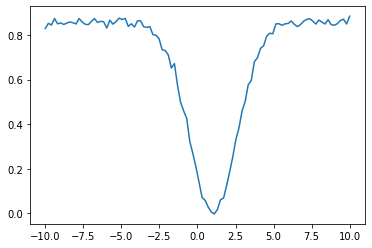

In [130]:
n=2**11
d=1
s=1
n_cont = 0
theta_star=np.ones(d)
data = sample_gaussian_outl(n,d,s,theta_star,n_cont=n_cont) 
l = np.sqrt((1/2)*np.median(distance.cdist(data,data,'sqeuclidean')))
kxx = k(data,data,l)[0]
thetas = np.linspace(-10,10,100)
MMDs = []
for i, t in enumerate(thetas):
    MMDs.append(MMD(t,data,kxx,l))
plt.plot(thetas, MMDs)

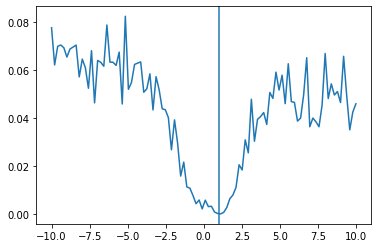

In [52]:
n=2**11
d=1
s=1
p=4
n_cont = 0
theta_star=np.array([3,1,1,-np.log(2)]) 
data = sample_gandk_outl(n,d,theta_star,n_cont=n_cont) 
#l = np.sqrt((1/2)*np.median(distance.cdist(data,data,'sqeuclidean')))
l=0.1
kxx = k(data,data,l)[0]
thetas = np.zeros((p,100))
theta1 = np.linspace(-10,10,100)
thetas[0,:] = 3*np.ones(100)
thetas[1,:] = np.ones(100)
thetas[2,:] = theta1  #np.ones(100)
thetas[3,:] = -np.log(2)*np.ones(100)
MMDs = []

for i in range(100):
    t = thetas[:,i]
    MMDs.append(MMD(t,data,kxx,l))
    #print(MMDs)
plt.plot(thetas[2,:], MMDs)
plt.axvline(theta_star[2])
# fig, ax_array = plt.subplots(2,2, figsize=(10,10))
# for ax, i in zip(ax_array.flatten(), range(0, p * n_cont)):
#     ax.plot(thetas[i,:], MMDs)
#     ax.set_xlabel('theta_{}'.format(i))
# fig, ax_array

In [49]:
theta_star[3]

-0.6931471805599453

(<Figure size 504x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5bcc5aed0>,
       dtype=object))

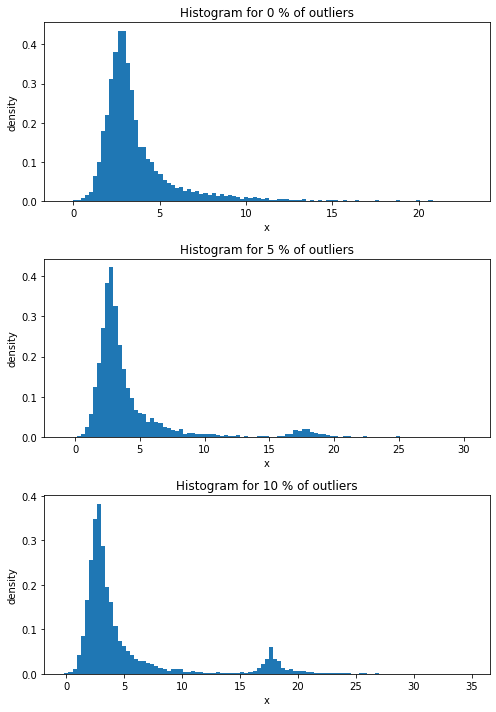

In [50]:
plot_gandk(x,3,(7,10),theta_star)

### Data simulation: $(X_1,\dots,X_n)$.

In [2]:
# Sample a dataset of size n from univariate Gaussians with a portion of outliers
def datagen(n,theta,contamination = []):
    datag = np.random.normal(loc=theta,scale=1,size=n-np.size(contamination))
    datag = np.concatenate((datag,contamination),axis=0)
    return np.matrix(datag)

## Box-Muller transformation

Box-Muller transformation:

In [57]:
def boxmuller(unif1,unif2):
    u1 = np.sqrt(-2*np.log(unif1))*np.cos(2*np.pi*unif2)
    u2 = np.sqrt(-2*np.log(unif1))*np.sin(2*np.pi*unif2)
    return np.transpose(np.vstack([u1,u2]))

Function generating standard normals using the box-muller transformation:

In [58]:
def normals(n, d, unif, sv=False):

    # avoid origin
    unif[unif==0] = np.nextafter(0, 1)

    # if d is odd, add one dimension
    if d % 2 != 0:
        dim = d + 1
    else:
        dim = d

    # expand dimensions for SV model
    if sv == True:
        dim = 2+2*d

    # create standard normal samples
    u = np.zeros((n,dim))
    for i in np.arange(0,dim,2):
        u[:,i:(i+2)] = boxmuller(unif[:,i],unif[:,(i+1)])

    # if d is odd, drop one dimension
    if d % 2 != 0 or sv == True:
        u = np.delete(u,-1,1)

    return u

### Gaussian Kernel
Gaussian kernel $k(x,y)$, its gradient w.r.t. first element $\nabla_1k(x,y)$ and its second derivative w.r.t. to the second and first argument $\nabla_2\nabla_1k(x,y)$:

In [6]:
def k(x,y,l, sparse=False): 

    if sparse == True:
        x = x.astype('float32')
        y = y.astype('float32')
    
    # dimensions
    d = x.shape[1]
    dims = np.arange(d)
    
    # kernel
    kernel = np.exp(-(1/(2*l**2))*distance.cdist(x,y,'sqeuclidean'))
    
    if type(x) != np.ndarray: # using np.matrix.A to convert to ndarray
        x = x.A
    if type(y) != np.ndarray:
        y = y.A
    
    # first derivative
    grad_1 = -1*np.squeeze(np.subtract.outer(x,y)[:,[dims],:,[dims]], axis=0)*(1/l**2)*np.expand_dims(kernel, axis=0)
    
    #second derivative
    grad_21 = (1/l**2)*(np.expand_dims(np.expand_dims(np.eye(d), axis = 2), axis = 3)-np.einsum('ijk,ljk->iljk',np.squeeze(np.subtract.outer(x,y)[:,[dims],:,[dims]], axis=0),np.squeeze(np.subtract.outer(x,y)[:,[dims],:,[dims]], axis=0))*(1/l**2))*kernel
    
    return list([kernel, grad_1, grad_21])

### $MMD^2$ approximation

In [60]:
def MMD_approx(n,m,weights,kxx,kxy,kyy):
        """y_{i=1}^m iid from P_\theta, x_{i=1}^n iid from P_0
        kxx is nxn, kyy is mxm and kxy is nxm"""
        
        # first sum
        np.fill_diagonal(kyy, np.repeat(0,m)) # exclude k(y_i, y_i) (diagonal terms)
        sum1 = np.sum(kyy)
    
        # second sum
        #sum2 = np.sum(kxy)
        sum2 = np.sum(kxy*weights)
    
        # third sum
        np.fill_diagonal(kxx, np.repeat(0,n))
        #sum3 = np.sum(self.kxx)
        sum3 = np.sum(kxx*weights)
    
        #return (1/(m*(m-1)))*sum1-(2/(m*n))*sum2+(1/(n*(n-1)))*sum3
        return (1/(m*(m-1)))*sum1-(2/(m))*sum2+(1/(n-1))*sum3

In [110]:
def MMD_to_minimise(data,m,weights,kxx,n,d,s,p):
    
    l = np.sqrt((1/2)*np.median(distance.cdist(data,data,'sqeuclidean')))
    def MMD(theta):
        np.random.seed(11)
        sample = sample_gaussian_outl('MC',m,d,s,theta)
        kyy, k1yy, k2yy = k(sample,sample,l)
        kxy, k1xy = k(sample,data,l)[0:2]    #kyx
        
        # first sum
        np.fill_diagonal(kyy, np.repeat(0,m)) # exclude k(y_i, y_i) (diagonal terms)
        sum1 = np.sum(kyy)
    
        # second sum
        #sum2 = np.sum(kxy)
        sum2 = np.sum(kxy*weights)
    
        # third sum
        np.fill_diagonal(kxx, np.repeat(0,n))
        #sum3 = np.sum(self.kxx)
        sum3 = np.sum(kxx*weights)
    
        #return (1/(m*(m-1)))*sum1-(2/(m*n))*sum2+(1/(n*(n-1)))*sum3
        return (1/(m*(m-1)))*sum1-(2/(m))*sum2+(1/(n-1))*sum3
    
    def mmd_grad(theta):
        np.random.seed(11)
        #def grad_MMD(p,n,m,grad_g,weights,k1yy,k1xy):
        sample = sample_gaussian_outl('MC',m,d,s,theta)
        kyy, k1yy, k2yy = k(sample,sample,l)
        kxy, k1xy = k(sample,data,l)[0:2]    #kyx
        # grad_g 
        arg1 = np.expand_dims(np.eye(theta.shape[0]),axis=2)
        arg2 = (theta.shape[0],theta.shape[0],m)
        grad_g = np.broadcast_to(arg1,arg2) 
        # first sum
        prod1 = np.squeeze(np.einsum('ilj,imjk->lmjk', grad_g, np.expand_dims(k1yy,axis=1)))
        if prod1.ndim==2:
            np.fill_diagonal(prod1[:,:], 0)
            sum1 = np.sum(prod1)
        else:
            for i in range(p):
                np.fill_diagonal(prod1[i,:,:], 0)
            sum1 = np.einsum('ijk->i',prod1)
    
        # second sum
        k1xy[0,:,:] = k1xy[0,:,:]*weights
        k1xy[1,:,:] = k1xy[1,:,:]*weights
        prod2 = np.squeeze(np.einsum('ilj,imjk->lmjk', grad_g, np.expand_dims(k1xy,axis=1)))
        if prod2.ndim==2:
            sum2 = np.sum(prod2)
        else:
            sum2 = np.einsum('ijk->i',prod2)
    
        #return (2/(m*(m-1)))*sum1-(2/(n*m))*sum2
        return (2/(m*(m-1)))*sum1-(2/(m))*sum2
    
    optimization_result = minimize(MMD, np.zeros(2), 
                           method= 'BFGS', jac=mmd_grad, options={'disp': True})
        

        
    # return the value at optimum
    return optimization_result.x
    
    

### MMD$^2$ gradient approximation between $P_{\theta}$ and $\sum_{i=1}^n w_i \delta_{x_i}$:

In [62]:
def grad_MMD(p,n,m,grad_g,weights,k1yy,k1xy):
    
    # first sum
    prod1 = np.squeeze(np.einsum('ilj,imjk->lmjk', grad_g, np.expand_dims(k1yy,axis=1)))
    if prod1.ndim==2:
        np.fill_diagonal(prod1[:,:], 0)
        sum1 = np.sum(prod1)
    else:
        for i in range(p):
            np.fill_diagonal(prod1[i,:,:], 0)
        sum1 = np.einsum('ijk->i',prod1)
    
    # second sum
    k1xy[0,:,:] = k1xy[0,:,:]*weights
    k1xy[1,:,:] = k1xy[1,:,:]*weights
    prod2 = np.squeeze(np.einsum('ilj,imjk->lmjk', grad_g, np.expand_dims(k1xy,axis=1)))
    if prod2.ndim==2:
        sum2 = np.sum(prod2)
    else:
        sum2 = np.einsum('ijk->i',prod2)
    
    #return (2/(m*(m-1)))*sum1-(2/(n*m))*sum2
    return (2/(m*(m-1)))*sum1-(2/(m))*sum2

## Information metric

Approximation of the informatin metric $g_U(\theta)$:

In [63]:
def g_approx(p,m,grad_g,k21xx):
    
    # sum
    grad_g_T = np.einsum('ijk -> jik',grad_g)
    prod1 = np.einsum('ijk, jlkm -> ilkm', grad_g_T, k21xx)
    prod2 = np.einsum('ijkl,jmk->imkl', prod1, grad_g)
    for i in range(p):
        np.fill_diagonal(prod2[i,i,:,:], 0)
    gsum = np.einsum('ijkl->ij', prod2)
    
    return 1/(m*(m-1))*gsum

## Generator

Generator $G_\theta(u)$ and generator gradient $\nabla_\theta G_\theta(u)$ for the **Gaussian location model**:

In [64]:
# generator
def gen_gaussian(n, d, unif, theta, sigma):

    unif[unif==0] = np.nextafter(0, 1)

    # if d is odd, add one dimension
    if d % 2 != 0:
        dim = d + 1
    else:
        dim = d

    # create standard normal samples
    u = np.zeros((n,dim))
    for i in np.arange(0,dim,2):
        u[:,i:(i+2)] = boxmuller(unif[:,i],unif[:,(i+1)])

    # if d is odd, drop one dimension
    if d % 2 != 0:
        u = np.delete(u,-1,1)

    # generate samples
    x = theta + u*sigma

    return x

# gradient of the generator
def grad_gen_gaussian(m, theta):
    arg1 = np.expand_dims(np.eye(theta.shape[0]),axis=2)
    arg2 = (theta.shape[0],theta.shape[0],m)
    return np.broadcast_to(arg1,arg2)    

Function to sample from **Gaussian location model**:



In [65]:
def sample_gaussian_outl(method_sampling,n,d,s,theta,n_cont = 0):   # set n_cont to zero if you don't want outliers

    ' caveat:                                                                 '
    ' the qmc or qmc_1 sequence have to be fixed before using this function   '
    
    cont_size = int(np.floor(int(n_cont)*5/100*n))
    n_real = n - cont_size
    
    # odd number of parameters
    if d % 2 != 0: 
        if method_sampling == 'MC':
            unif = np.random.rand(n_real,d+1)
        if method_sampling == 'QMC':
            unif = qmc_1.gen_samples(n_real)
        if method_sampling == 'RQMC':
            unif = qmcpy.Halton(d+1).gen_samples(n_real)

    # even number of parameters
    else: 
        if method_sampling == 'MC':
            unif = np.random.rand(n_real,d)
        if method_sampling == 'QMC':
            unif = qmc.gen_samples(n_real)
        if method_sampling == 'RQMC':
            unif = qmcpy.Halton(d).gen_samples(n_real)

    # use generator  
    if n_cont != 0:
        outl = np.asmatrix(np.random.normal(loc=5,scale=1,size=cont_size)).transpose()
        sample_ = gen_gaussian(n_real,d,unif,theta,s) 
        x = np.concatenate((sample_, outl), axis=0)
    else:
        x = gen_gaussian(n_real,d,unif,theta,s)
        
    return x

### Computation of the Maximum Likelihood Estimator (the mean) $\frac{1}{n}\sum_{i=1}^n X_i$ and the geometric median

In [66]:
def MLE(data):
    return(np.mean(data))

In [67]:
def GEO_MED(data):
    return(np.median(data))

### NPL
For Generative models

In [68]:
class NPL():
    """This class contains everything that is needed for inference with a 
    given model. 
    """
    
    def __init__(self, X, B, m, s, p, l, method_gd = 'SGD'):
        self.B = B  # number of bootstrap iterations
        self.m = m  # number of points sampled from P_\theta at each optim. iteration
        self.s = s  # standard deviation of the model 
        self.p = p  # number of unknown parameters
        self.X = X  # data
        self.n, self.d = self.X.shape   # dims of data
        self.method_gd = method_gd # optim. method: SGD or NSGD
        self.l = l  # lengthscale of gaussian kernel
        # median heuristic if l=-1 
        if self.l == -1:
            self.l = np.sqrt((1/2)*np.median(distance.cdist(self.X,self.X,'sqeuclidean')))
        self.kxx = k(self.X,self.X,self.l)[0]
        
        
    def draw_single_sample(self, bootstrap_it):
        
        # draw Dirichlet weights
        weights = dirichlet.rvs(np.ones(self.n), size = 1).flatten()   # ranodm state?
        # compute WLL minimizer
        wll_j = self.WLL(self.X, weights)  
        # compute MMD minimizer
        theta_j, loss_j, gd_losses_j = self.minimise_MMD(self.X, weights)    
        
        return theta_j, wll_j, loss_j, gd_losses_j
        
    
    def draw_samples(self, seed=0):
        """Draws B samples from the nonparametric posterior specified via
        the likelihood and the data X"""
        
        print("Drawing samples...")    
        
        sample = np.zeros((self.B,self.p))
        wll = np.zeros((self.B,self.p))
        mmd_loss = np.zeros((self.B,self.p))
        
        # Parallelize
        # temp = Parallel(n_jobs=-1, backend= 'loky', max_nbytes = "50M" )(delayed(self.draw_single_sample)(X, self.n) for j in tqdm(range(self.B)))  
        if __name__ == '__main__':
            pool = Pool()               # Create a multiprocessing Pool - defualt arg. is max number of n_cores
            temp = pool.map(self.draw_single_sample, tqdm(range(self.B))) 
        
        for i in range(self.B):
            sample[i,:] = temp[i][0]
            wll[i,:] = temp[i][1]
            mmd_loss[i,:] = temp[i][2]
            # gd_losses
                    
        self.sample = np.array(sample)
        self.wll = np.array(wll)
        self.mmd_loss = np.array(mmd_loss)
    
    # generator
    def gen_gaussian(self, unif, theta):

        unif[unif==0] = np.nextafter(0, 1)

        # if d is odd, add one dimension
        if self.d % 2 != 0:
            dim = self.d + 1
        else:
            dim = self.d

        # create standard normal samples
        u = np.zeros((self.m,dim))
        for i in np.arange(0,dim,2):
            u[:,i:(i+2)] = boxmuller(unif[:,i],unif[:,(i+1)])

        # if d is odd, drop one dimension
        if self.d % 2 != 0:
            u = np.delete(u,-1,1)

       # generate samples
        x = theta + u*self.s

        return x

    # gradient of the generator
    def grad_gen_gaussian(self,theta):
        return np.broadcast_to(np.expand_dims(np.eye(theta.shape[0]),axis=2),(theta.shape[0],theta.shape[0],self.m))
    
    def g_approx(self,grad_g, k2yy):
        # sum
        grad_g_T = np.einsum('ijk -> jik',grad_g)
        prod1 = np.einsum('ijk, jlkm -> ilkm', grad_g_T, k2yy)
        prod2 = np.einsum('ijkl,jmk->imkl', prod1, grad_g)
        for i in range(self.p):
            np.fill_diagonal(prod2[i,i,:,:], 0)
        gsum = np.einsum('ijkl->ij', prod2)
    
        return 1/(self.m*(self.m-1))*gsum

    def sample_gaussian(self,method_sampling,theta):

        ' caveat:                                                                 '
        ' the qmc or qmc_1 sequence have to be fixed before using this function   '

        # odd number of parameters
        if self.d % 2 != 0: 
            if method_sampling == 'MC':
                unif = np.random.rand(self.m,self.d+1)
            if method_sampling == 'QMC':
                unif = qmc_1.gen_samples(self.m)
            if method_sampling == 'RQMC':
                unif = qmcpy.Halton(d+1).gen_samples(self.m)

        # even number of parameters
        else: 
            if method_sampling == 'MC':
                unif = np.random.rand(self.m,self.d)
            if method_sampling == 'QMC':
                unif = qmc.gen_samples(self.m)
            if method_sampling == 'RQMC':
                unif = qmcpy.Halton(d).gen_samples(self.m)

        # use generator  
        x = self.gen_gaussian(unif,theta)

        return x
    
    def MMD_approx(self,weights,kxy,kyy):
        """y_{i=1}^n iid from P_\theta, x_{i=1}^m iid from Q
        kxx is nxn, kyy is mxm and kxy is nxm"""
        
        # first sum
        np.fill_diagonal(kyy, np.repeat(0,self.m)) # exclude k(y_i, y_i) (diagonal terms)
        sum1 = np.sum(kyy)
    
        # second sum
        sum2 = np.sum(kxy*weights)
    
        # third sum
        np.fill_diagonal(self.kxx, np.repeat(0,self.n))
        kxx = self.kxx*weights
        sum3 = np.sum(kxx)
    
        return (1/(self.m*(self.m-1)))*sum1-(2/(self.m*self.n))*sum2+(1/(self.n*(self.n-1)))*sum3
    
    
    def grad_MMD(self,weights,grad_g,k1yy,k1xy):
        # y sample from p_theta, x data
        # first sum
        prod1 = np.squeeze(np.einsum('ilj,imjk->lmjk', grad_g, np.expand_dims(k1yy,axis=1)))
        if prod1.ndim==2:
            np.fill_diagonal(prod1[:,:], 0)
            sum1 = np.sum(prod1)
        else:
            for i in range(self.p):
                np.fill_diagonal(prod1[i,:,:], 0)
            sum1 = np.einsum('ijk->i',prod1)

        # second sum
        k1xy[0,:,:] = k1xy[0,:,:]*weights
        # 
        prod2 = np.squeeze(np.einsum('ilj,imjk->lmjk', grad_g, np.expand_dims(k1xy,axis=1)))
        if prod2.ndim==2:
            sum2 = np.sum(prod2)
        else:
            sum2 = np.einsum('ijk->i',prod2)
    
        return (2/(self.m*(self.m-1)))*sum1-(2/(self.n*self.m))*sum2


    def minimise_MMD(self, data, weights, Nstep=2000, eta=0.1):
        """Gaussian kernel of parameter gamma=1
        Minibatch size = sample size = n, number of iterations = Nstep = 10000"""
        """MMD minimzer between P^(j) for \alpha=0 and P_\theta using PSGD"""
        theta = np.zeros(self.d) #np.mean(data)*np.ones(self.d)   # initialize with the MLE
        t = 0
        gradient = 100
        gd_losses = []
        gd_losses.append(0)
        current_loss = 10
        while t < Nstep: #and np.linalg.norm(current_loss - gd_losses[t-1]) > 10e-6: 
            sample = self.sample_gaussian('MC',theta)
            kyy, k1yy, k2yy = k(sample,sample,self.l)
            kxy, k1xy = k(sample,data,self.l)[0:2]    #kyx
            current_loss = self.MMD_approx(weights,kxy,kyy)
            gd_losses.append(current_loss)
            grad_g = self.grad_gen_gaussian(theta)
            
            # approximate MMD gradient
            if self.p == 1:
                gradient = np.asmatrix(self.grad_MMD(weights,grad_g,k1yy,k1xy))
            else:
                gradient = self.grad_MMD(weights,grad_g,k1yy,k1xy)
                
            # approximate information metric
            # pre-define noise for information metric
            noise = [0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
            
            if self.method_gd == 'NSGD':
                g = self.g_approx(grad_g, k2yy)
                # add noise if g can't be inverted
                for j in range(9):
                    check = True
                    try:
                        np.linalg.inv(g + np.eye(self.p)*noise[j])
                    except np.linalg.LinAlgError:
                        check = False
                    if check:
                        break
                g = g + np.eye(self.p)*noise[j]
            
            # update theta according to optimization method
            if self.method_gd == 'SGD':
                theta = theta-eta*gradient
            else:
                theta = theta-eta*np.linalg.inv(g)@gradient
            
            t += 1
        #print("stopped after", t, "steps")
        loss = self.MMD_approx(weights,kxy,kyy)
        return theta, loss, gd_losses
        
    def WLL(self, data, weights):
        """Get weighted log likelihood minimizer, for gaussian model"""
        theta = 0
        for i in range(self.n):
            theta += weights[i]*data[i] 
        return theta

### Inference

In [19]:
start_time = time.time()
n = 2**11
m = 2**9
d = 2
s = 1
l = -1
theta_star = np.ones(d)
#N = 1
B = 1
outl = 1
method = 'SGD'
results = np.zeros((3,outl)) # each of the rows are MMD, MLE, WLL resp.
for n_cont in np.arange(outl):
    #for i in range(N):
    print("-----Running for", n_cont*5, "% of outliers-----")
    X = sample_gaussian_outl('MC',n,d,s,theta_star,n_cont=n_cont)
    npl = NPL(X,B,m,s,d,l,method_gd = method)
    npl.draw_samples(X)
    sample = npl.sample
    wll_sample = npl.wll
    mmd_loss = npl.mmd_loss
    sample_mmd = np.mean(sample, axis=0)
    sample_mle = np.mean(X, axis=0)
    sample_wll = np.mean(wll_sample, axis=0)
    results[0, n_cont] = mean_squared_error(theta_star, sample_mmd)
    results[1, n_cont] = mean_squared_error(theta_star, sample_mle)
    results[2, n_cont] = mean_squared_error(theta_star, sample_wll)
end_time = time.time()
print('Time :', end_time-start_time, 'seconds')
for n_cont in np.arange(outl):
    print('MSE of MMD for', n_cont*5, '% of outliers :', (results[0, n_cont]))
    print('MSE of MLE for', n_cont*5, '% of outliers :', (results[1, n_cont]))
    print('MSE of WLL for', n_cont*5, '% of outliers :', (results[2, n_cont]))

-----Running for 0 % of outliers-----
Drawing samples...



Time : 217.67817997932434 seconds
MSE of MMD for 0 % of outliers : 0.47929304837714176
MSE of MLE for 0 % of outliers : 8.631735998973463e-05
MSE of WLL for 0 % of outliers : 5.542585369023998e-05


Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Process ForkPoolWorker-4:
Process ForkPoolWorker-10:
Process ForkPoolWorker-7:
Process ForkPoolWorker-1:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/pr

In [23]:
sample

array([[0.0209572 , 1.00782906]])

### Plot results

In [ ]:
fig = plt.figure(figsize=(18, 18))

plt.plot(np.linspace(0,4*outl,outl), results[0,:], 'r--', label='MMD')
plt.plot(np.linspace(0,4*outl,outl), results[1,:], 'b--', label='MLE')
plt.plot(np.linspace(0,4*outl,outl), results[2,:], 'g--', label='WLL')
#plt.plot(arange(0,0.225,0.025), vec_res[arange(outl)*3+2], 'g--', label='MED')
#plt.plot(arange(0,0.30,0.05), vec_res[arange(outl)*4+3], 'p+-', label='VI')
leg = plt.legend(loc='best', ncol=1)
leg.get_frame().set_alpha(0.5)
plt.xlabel('Percentage of outliers',fontsize='x-large')
plt.ylabel('MSE',fontsize='x-large')

# plt.subplot(1, 2, 2)
# plt.plot(arange(0,0.225,0.025), vec_res[arange(outl)*3+0], 'r--', label='MMD')
# plt.plot(arange(0,0.225,0.025), vec_res[arange(outl)*3+2], 'g--', label='MED')
# #plt.plot(arange(0,0.30,0.05), vec_res[arange(outl)*4+3], 'p+-', label='VI')
# leg = plt.legend(loc='best', ncol=1)
# leg.get_frame().set_alpha(0.5)
# plt.xlabel('Ratio of outliers',fontsize='x-large')
# plt.ylabel('Sqrt of MSE',fontsize='x-large')

fig.set_size_inches(12, 4)

plt.tight_layout()

In [ ]:
plt.plot(range(B), mmd_loss, label='MMD')
leg = plt.legend(loc='best', ncol=1)
leg.get_frame().set_alpha(0.5)
plt.xlabel('Bootstrap iteration',fontsize='x-large')
plt.ylabel('MMD^2 loss',fontsize='x-large')

In [104]:
#np.savetxt(fname='02_res.txt', X=results)

In [ ]:
# old mmd function inside NPL class
#     def MMD(self, data, weights, Nstep=1000 ,gamma=1, eta=0.2):
#         """Gaussian kernel of parameter gamma=1
#         Minibatch size = sample size = n, number of iterations = Nstep = 1000"""
#         """MMD minimzer between P^(j) for \alpha=0 and P_\theta using PSGD"""
#         theta = 0.0
#         t = 0
#         gradient = 100
#         while t < Nstep and abs(gradient) > 0.0001: 
#            #print("---Performing step", t, "of SGD---")
#            #print("Minimizing MMD...")
#             sample = np.random.normal(loc=theta,scale=1,size=self.n) 
#             K1 = self.outerdiff(v1=sample,v2=data)
#             K2 = self.outerdiff(v1=sample,v2=sample)
#             diff = theta*np.ones(self.n)-sample
#             weights_mat = np.tile(weights, (self.n,1))
#         #gradient = -2*(mean(diff*(exp(-gamma*multiply(K2,K2))-diag(ones(n))))/(n-1)-mean(diff*exp(-gamma*multiply(K1,K1))))
#             gradient = -2*np.mean(diff*(np.exp(-gamma*np.multiply(K2,K2))-np.diag(np.ones(self.n)))/(self.n-1)-
#                             sum(diff*np.multiply(weights_mat, np.exp(-gamma*np.multiply(K1,K1)))))
#             theta = theta-eta*gradient/np.sqrt(t+1)
#             t += 1
#         #print("stopped after", t, "steps")
#         return theta

### Test MMD convergence

In [124]:
def MMD_(data, weights, m, Nstep=1000 ,gamma=-1, eta=0.1):
    """Gaussian kernel of parameter gamma=1
    Minibatch size = sample size = n, number of iterations = Nstep = 1000"""
    """MMD minimzer between P^(j) for \alpha=0 and P_\theta using PSGD"""
    n, d = data.shape
    #print(d)
    theta = np.zeros(d)#MLE(data)*np.ones(d)
    thetas = []
    grads = []
    losses = []
    t = 0
    #gradient = 100
    # median heuristic if gamma=-1
    if gamma == -1:
        gamma = np.sqrt((1/2)*np.median(distance.cdist(data,data,'sqeuclidean')))
    kxx = k(data,data,gamma, sparse=True)[0]
    while t < Nstep: #and np.linalg.norm(gradient) > 10e-6: 
        sample = sample_gaussian_outl('MC',m,d,1,theta, n_cont=0)
        kyy, k1yy = k(sample,sample,gamma,sparse=True)[0:2]
        kxy, k1xy = k(sample,data,gamma, sparse=True)[0:2]    #kyx
        grad_g = grad_gen_gaussian(m,theta)
        if d == 1:
            gradient = np.asmatrix(grad_MMD(d,n,m,grad_g,weights,k1yy,k1xy))
        else:
            gradient = grad_MMD(d,n,m,grad_g,weights,k1yy,k1xy)
            #print(gradient)
        #print(np.shape(gradient))
        #print(theta,t)
        #print(gradient,t)
        theta = theta-eta*gradient
        #print(theta)
        loss = MMD_approx(n,m,weights,kxx,kxy,kyy)
        losses.append(loss)
        thetas.append(theta)
        t += 1
    #print("stopped after", t, "steps")
    return theta, np.squeeze(np.asarray(thetas)), losses, t

In [100]:
def MMD_new(data, weights, m, Nstep=1000 ,gamma=-1, eta=0.1):
    """Gaussian kernel of parameter gamma=1
    Minibatch size = sample size = n, number of iterations = Nstep = 1000"""
    """MMD minimzer between P^(j) for \alpha=0 and P_\theta using PSGD"""
    n, d = data.shape
    #print(d)
    theta = np.zeros(d)#MLE(data)*np.ones(d)
    thetas = []
    grads = []
    losses = []
    t = 0
    s=1
    #gradient = 100
    # median heuristic if gamma=-1
    if gamma == -1:
        gamma = np.sqrt((1/2)*np.median(distance.cdist(data,data,'sqeuclidean')))
    kxx = k(data,data,gamma, sparse=True)[0]
    p = d
    theta = MMD_to_minimise(data,m,weights,kxx,n,d,s,p)
        #print(theta)
    #loss = MMD_approx(n,m,weights,kxx,kxy,kyy)
    #losses.append(loss)
    #thetas.append(theta)
        
    #print("stopped after", t, "steps")
    return theta

In [92]:
def mse(max_it,p,thetas,theta_star):
    mse_ = np.zeros((max_it-1,p))
    for l in range(p):
        for j in range(max_it-1):
            mse_[j,l] = np.mean(np.asarray((thetas[1:j+2]-theta_star[l]))**2)
    return mse_

In [93]:
n=2**11
m=2**9
d=2
s=1
theta_star=np.ones(2)
n_cont = 0
weights = dirichlet.rvs(np.ones(n), size = 1).flatten()
#weights = np.ones(n)
X = sample_gaussian_outl('MC',n,d,s,theta_star,n_cont=n_cont)      
theta_estimate, thetas, losses, iterations = MMD_(X, weights, m)

NameError: name 'MMD_' is not defined

In [113]:
# new 
n=2**11
m=2**9
d=2
s=1
theta_star=np.ones(2)
n_cont = 0
weights = dirichlet.rvs(np.ones(n), size = 1).flatten()
#weights = np.ones(n)
X = sample_gaussian_outl('MC',n,d,s,theta_star,n_cont=n_cont)      
theta_estimate = MMD_new(X, weights, m)

Optimization terminated successfully.
         Current function value: 0.000740
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8


In [114]:
theta_estimate

array([0.96799782, 1.03335516])

<function matplotlib.pyplot.show(*args, **kw)>

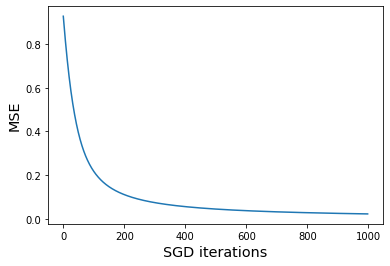

In [127]:
iterations = 1000
theta_star = np.ones(2)
mses = mse(iterations,1,thetas,theta_star)[:,0]
plt.plot(range(iterations-1),mses)
plt.xlabel('SGD iterations',fontsize='x-large')
plt.ylabel('MSE',fontsize='x-large')

plt.show

Text(0, 0.5, 'MMD^2 loss')

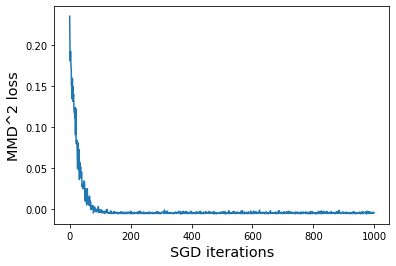

In [128]:
plt.plot(range(iterations), losses)
plt.xlabel('SGD iterations', fontsize='x-large')
plt.ylabel('MMD^2 loss', fontsize='x-large')

In [68]:
def func(a):
    c = a**2
    d = a**3 
    return c, d

In [7]:
if __name__ == '__main__':
    pool = Pool()              
    temp = pool.map(func, range(5)) 

In [113]:
m = 1000              # number of simulated samples
n = 1500              # number of true samples
theta = np.ones(2)    # true theta
d = len(theta)        # dimensions of data
p = d                 # dimensions of parameter space
s = 2                 # standard deviation of the model
l = -1                # lengthscale (l=-1 for median heuristic)

In [114]:
y = sample_gaussian_outl('MC',m,d,s,theta)
x = sample_gaussian_outl('MC',n,d,s,theta)

In [115]:
kxx = k(x,x,l)
kxy = k(y,x,l)
kyy = k(y,y,l)
k1yy = kyy[1]
k1xy = kxy[1]
k21xx = kxx[2]
grad_g = grad_gen_gaussian(m, theta)

In [116]:
np.shape(k1xy[1])

(1000, 1500)

In [117]:
# check gradient using finite differences
weights = (1/n)*np.ones(n)
print('check gradient of the MMD^2 approximation:')
print((MMD_approx(n,m,weights,kxx[0],k(y+0.00000001,x,l)[0],k(y+0.00000001,y+0.00000001,l)[0])-MMD_approx(n,m,weights,kxx[0],kxy[0],kyy[0]))/0.00000001)
print(np.sum(grad_MMD(p,n,m,grad_g,weights,k1yy,k1xy)))

check gradient of the MMD^2 approximation:
-0.00212683204381392
-0.0021268271245530584
